### Load libraries

In [1]:
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

### Load data

In [2]:
def get_cifar_data() -> tuple[np.ndarray, np.ndarray]:
    # Check if file exists:
    if (GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz").exists():
        d = np.load(GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz")
    else:
        d = np.load("/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz")

    xs_train, ys_train = d["xs_train"], d["ys_train"]
    xs_test, ys_test = d["xs_test"], d["ys_test"]

    xs, ys = np.concatenate([xs_train, xs_test]), np.concatenate([ys_train, ys_test])
    return xs, ys

CIFAR_XS, CIFAR_YS = get_cifar_data()

In [3]:
# Fit a GMM to the CIFAR-10 data

def fit_gmm(xs: np.ndarray, n_components: int) -> GaussianMixture:
    gmm = GaussianMixture(n_components=n_components, n_init=1)
    gmm.fit(xs)
    return gmm

def fit_gmms(xs: np.ndarray, ys: np.ndarray, n_components: int) -> list[GaussianMixture]:
    gmms = []
    for i in range(10):
        gmm = fit_gmm(xs[ys == i], n_components)
        gmms.append(gmm)
    return gmms

GMMS = fit_gmms(CIFAR_XS, CIFAR_YS, 1)

In [4]:
# Generate a bunch of samples from the GMMs (vectorized)
YS = np.random.choice(10, size=60000)
XS = np.zeros((60000, CIFAR_XS.shape[-1]))
for i in range(10):
    xs = GMMS[i].sample((YS == i).sum())[0]
    XS[YS == i] = xs

XS_TRAIN, YS_TRAIN = XS[:50000], YS[:50000]
XS_TEST, YS_TEST = XS[50000:], YS[50000:]

XS_TRAIN.shape, YS_TRAIN.shape, XS_TEST.shape, YS_TEST.shape

((50000, 768), (50000,), (10000, 768), (10000,))

### Experiment code

In [5]:
def get_min_xent(probs: np.ndarray, labs: np.ndarray) -> float:
    logits = np.log(probs)

    def get_xent(alpha: float) -> float:
        tlogits = logits * alpha
        tprobs = scipy.special.softmax(tlogits, axis=1)
        return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()

    res = scipy.optimize.minimize_scalar(get_xent, bounds=(0.01, 100))
    return res.fun

def run_experiment(
    n_train: int,
    n_classes: int,
    C: float,
    max_iter: int,
    seed: int = 0,
    debug: bool = False,
):
    param_dict = {
        "n_train": n_train,
        "n_classes": n_classes,
        "C": C,
        "max_iter": max_iter,
        "seed": seed,
    }

    # Get first n_classes classes
    classes = np.arange(n_classes)

    # Subset train data to chosen classes.
    mask_train = np.isin(YS_TRAIN, classes)
    xs_train = XS_TRAIN[mask_train]
    ys_train = YS_TRAIN[mask_train]

    # Subset test data to chosen classes.
    mask_test = np.isin(YS_TEST, classes)
    xs_test = XS_TEST[mask_test]
    ys_test = YS_TEST[mask_test]

    # Possibly reduce n_train if there are not enough train samples.
    n_train = min(n_train, len(xs_train))

    # Subset train data to size n_train
    idx = np.random.choice(len(xs_train), n_train, replace=False)
    xs_train = xs_train[idx]
    ys_train = ys_train[idx]

    # Handle case where we only have one class
    if ys_train.min() == ys_train.max():
        acc = (ys_test == ys_train[0]).mean()
        return param_dict | {"acc": acc, "xent": np.infty}

    # Train a logistic regression classifier on the training data
    clf = LogisticRegression(
        random_state=seed,
        max_iter=max_iter,
        multi_class="multinomial",
        **({"C": C, "penalty": "l2"} if C > 0 else {"penalty": "none"}),
    )
    clf.fit(xs_train, ys_train)

    # Evaluate the classifier on the test data
    acc = clf.score(xs_test, ys_test)

    # Compute cross-entropy loss on the test data
    ys_test_reordered = ys_test.copy()
    for i, cls in enumerate(clf.classes_):
        ys_test_reordered[ys_test == cls] = i

    xent = get_min_xent(
        clf.predict_proba(xs_test),
        ys_test_reordered
    ) if np.isin(ys_test, clf.classes_).all() else np.infty

    ret_dict = param_dict | {"acc": acc, "xent": xent}
    if debug:
        ret_dict["probs"] = clf.predict_proba(xs_test)
        ret_dict["ys_test_reordered"] = ys_test_reordered

    return ret_dict

### Collect scaling data

In [6]:
DATA = []

In [7]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    run_experiment(
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
for n_train in tqdm([5000, 10000, 50000]):
    for C in [0.01]:
        for seed in range(1):
            for n_classes in [2, 5, 10]:
                with np.errstate(divide='ignore'):
                    DATA.append(
                        run_experiment(
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                    )

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze data

In [17]:
df = pd.DataFrame(DATA)
df["err"] = 1 - df.acc

# Load original data
df_orig = pd.read_csv("clip-cifar-scaling.csv")
df

,n_train,n_classes,C,max_iter,seed,acc,xent,err
0,1,2,0.01,10000,0,0.515784,inf,0.484216
1,1,5,0.01,10000,0,0.193647,inf,0.806353
2,1,10,0.01,10000,0,0.095100,inf,0.904900
3,1,2,0.01,10000,1,0.515784,inf,0.484216
4,1,5,0.01,10000,1,0.206272,inf,0.793728
...,...,...,...,...,...,...,...,...
1804,10000,5,0.01,10000,0,0.999796,0.000626,0.000204
1805,10000,10,0.01,10000,0,0.998600,0.004763,0.001400
1806,50000,2,0.01,10000,0,1.000000,-0.000000,0.000000
1807,50000,5,0.01,10000,0,0.999796,0.000428,0.000204


In [14]:
# df.to_csv("clip-cifar-gmm-scaling.csv", index=False)

### CLIP scaling

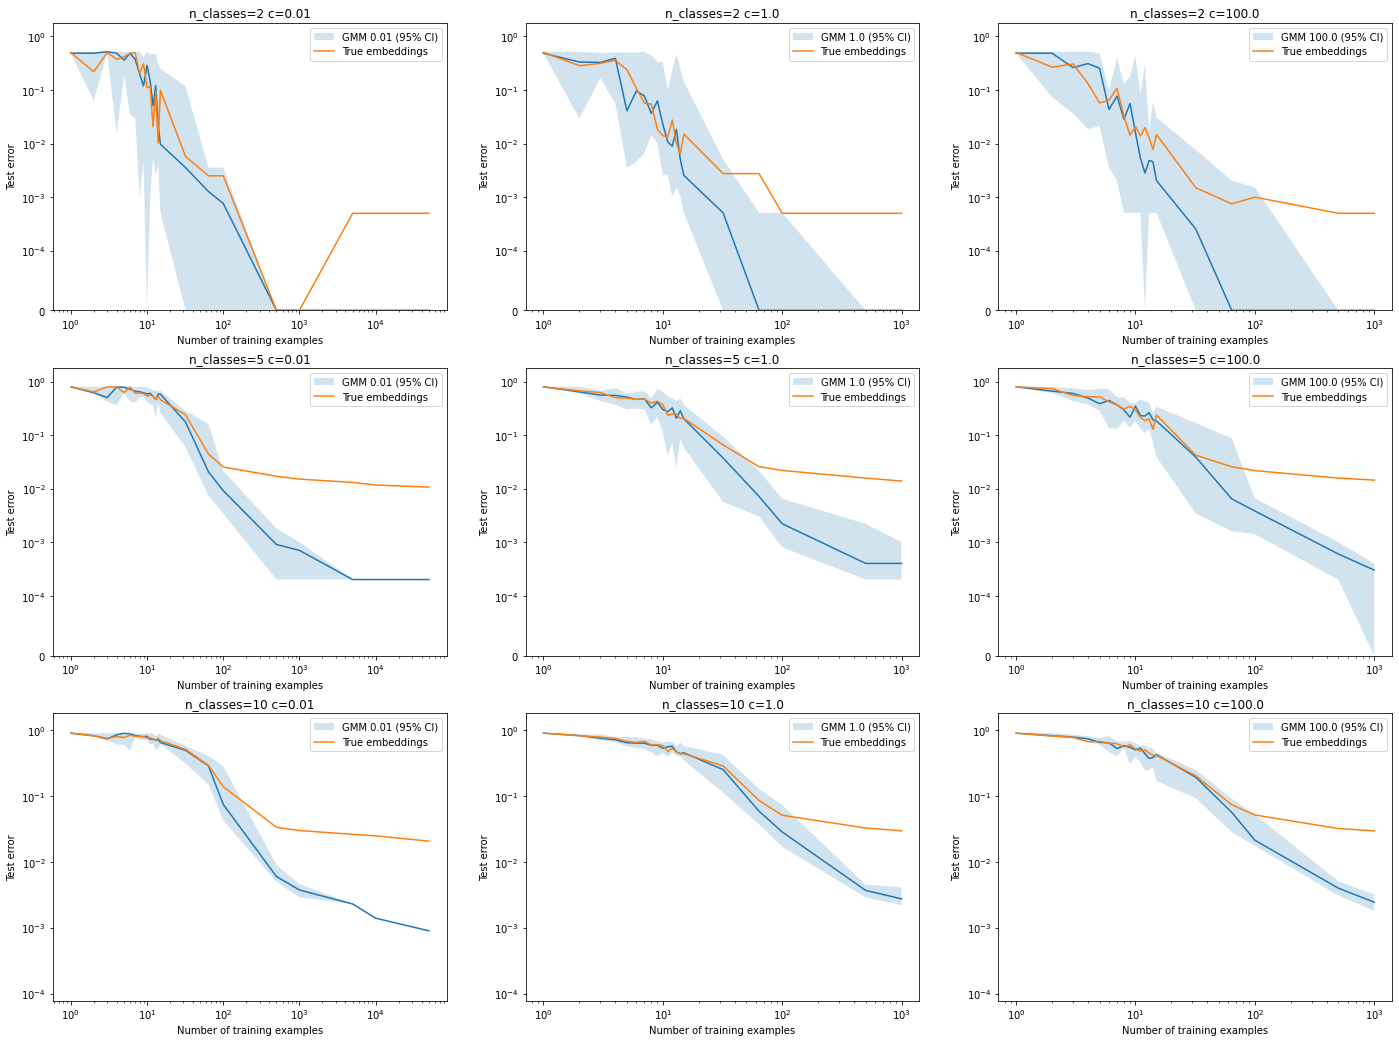

In [20]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"GMM {c} (95% CI)"
        )

        gbo = df_orig.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        mid = gbo.median()
        plt.plot(mid.index, mid, label="True embeddings")

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

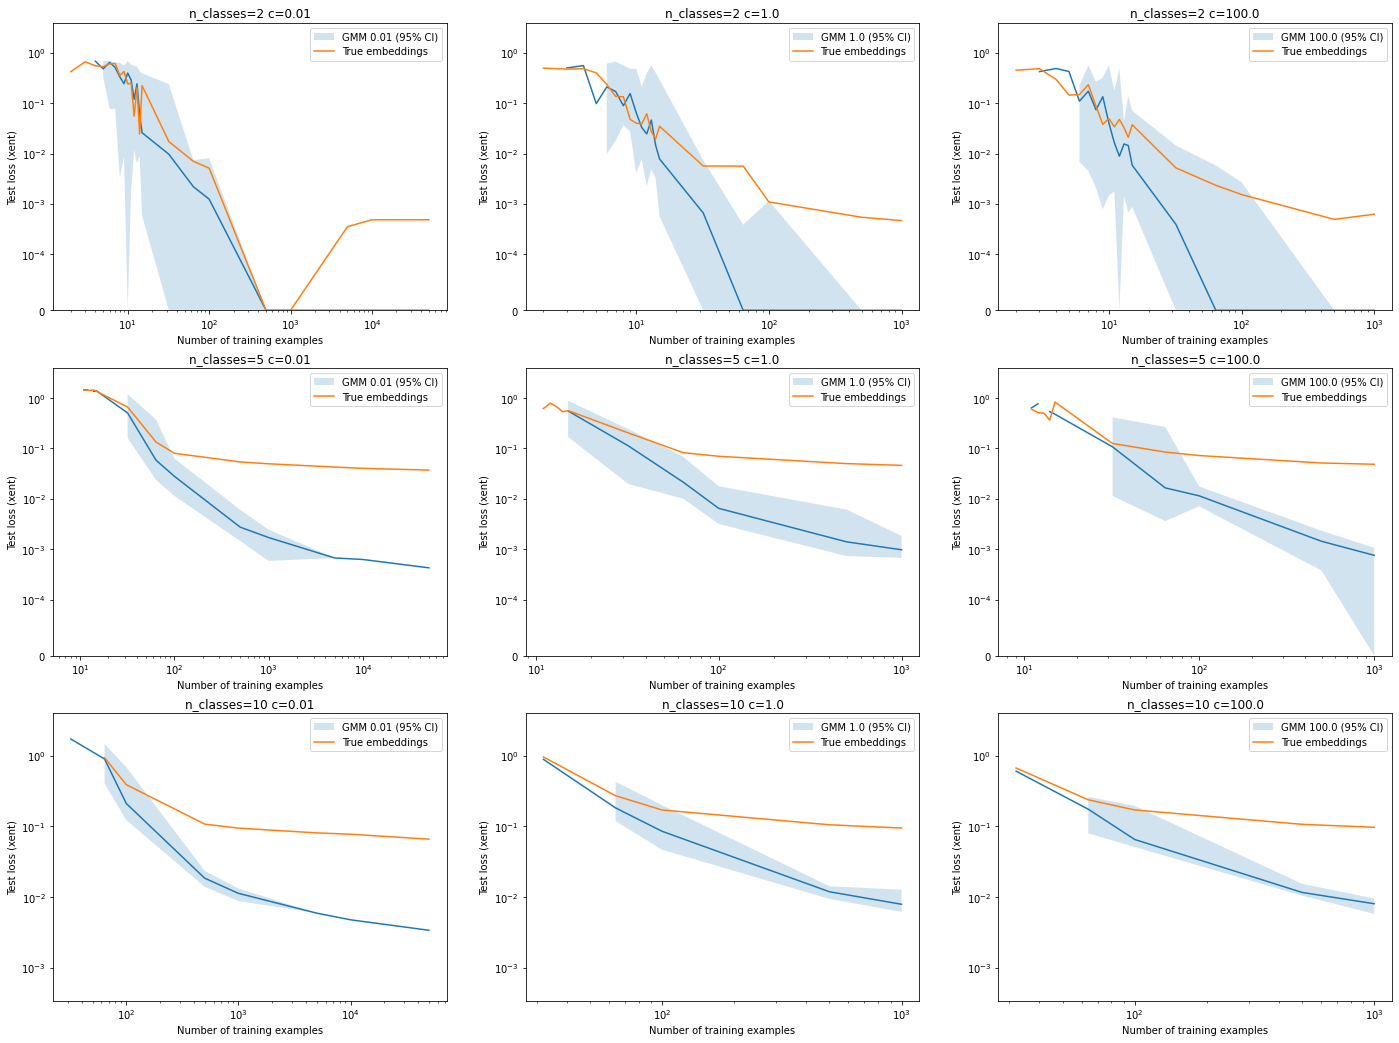

In [21]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"GMM {c} (95% CI)"
        )

        gbo = df_orig.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        mid = gbo.median()
        plt.plot(mid.index, mid, label="True embeddings")

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")

One thing to note about the above plots: The last three points are only single samples and do not have error bars!